<a href="https://colab.research.google.com/github/bogatovam/ml-course-hse/blob/master/ML_LAB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Дан датасет бронирований отеля. Необходимо предсказать, будет отменено то или иное бронирование или нет.

In [1]:
import numpy as np              
import matplotlib.pyplot as plt 
%matplotlib inline 
import pandas as pd            
import seaborn as sns           
import sklearn  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sns.set(style="darkgrid")

Загрузка данных

In [3]:
url = "https://github.com/bogatovam/ml-course-hse/raw/master/hotel_bookings.csv"
data_raw = pd.read_csv(url)

Датасет содержит 32 признака. Каждый из них подробно описан на странице датасета (https://www.sciencedirect.com/science/article/pii/S2352340918315191). Требуется предсказать бинарный признак is_canceled - указывающий, было ли бронирование отменено (1) или нет (0).

Преобразуем столбец `reservation_status_date` с типом дата в два числовых признака, разделив его соответственно на год, и номер дня, когда было сделано последнее бронирование.

In [4]:
data_raw['reservation_status_year'] = pd.DatetimeIndex(data_raw['reservation_status_date']).year
data_raw['reservation_status_day'] = pd.DatetimeIndex(data_raw['reservation_status_date']).dayofyear
del data_raw['reservation_status_date']

Изменим тип у всех категориальных признаков

In [5]:
for feature in data_raw.columns:
  if data_raw[feature].dtype == object:
    data_raw[feature] = data_raw[feature].astype('category')

In [6]:
country_codes = dict(zip(data_raw['country'].unique().tolist(), data_raw['country'].unique().codes.tolist()))

In [7]:
data_raw['country'] = data_raw['country'].cat.codes

In [8]:
data_raw.loc[data_raw.country ==-1, 'country'] = np.nan

Информация о виде каждого признака:

In [9]:
data_describe = data_raw.describe(include = ['category'])

numerical_features = [f for f in data_raw.columns if data_raw[f].dtype.name is not 'category']
categorical_features = [f for f in data_raw.columns if data_raw[f].dtype.name is 'category']
binary_columns    = [f for f in categorical_features if data_describe[f]['unique'] == 2]
nonbinary_columns = [f for f in categorical_features if data_describe[f]['unique'] > 2]

In [10]:
numerical_features

['is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'country',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status_year',
 'reservation_status_day']

In [11]:
binary_columns

['hotel']

In [12]:
nonbinary_columns

['arrival_date_month',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status']

### 2. Визуализация данных

In [13]:
 data_raw.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,country,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_year,reservation_status_day
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,118902.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,92.990076,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363,2016.093743,177.495376
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,44.676327,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798,0.715306,102.513594
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000,2014.000000,1.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000,2016.000000,89.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,81.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000,2016.000000,181.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,135.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000,2017.000000,264.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,176.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000,2017.000000,366.000000


In [14]:
 data_raw.describe(include = ['category'])

,hotel,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status
count,119390,119390,119390,119390,119390,119390,119390,119390,119390,119390
unique,2,12,5,8,5,10,12,3,4,3
top,City Hotel,August,BB,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out
freq,79330,13877,92310,56477,97870,85994,74053,104641,89613,75166


Выборка является несбалансированной: экземпляров бронирований без отмены быльше, чем с отменой

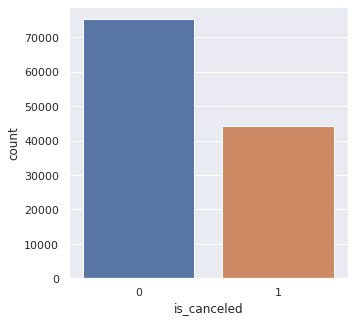

In [73]:
plt.figure(figsize = (5, 5))

sns.countplot(x='is_canceled', data=data_raw)
pass

Видна зависимость между отменой бронирования и временем до заселения, за которое было произведено бронирование. То есть, при рассмотрении довольно большого значения lead_time, бронирования отменяются чаще, нежели чем сохраняются.

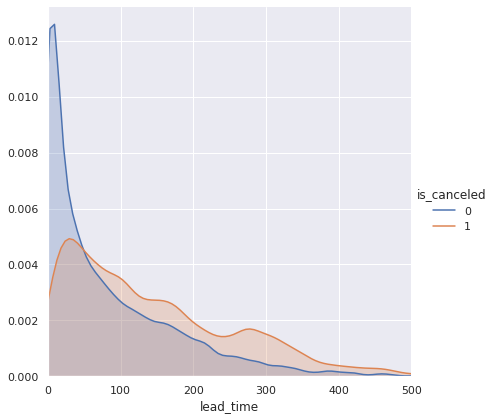

In [15]:
(sns.FacetGrid(data_raw, hue = 'is_canceled',
             height = 6,
             xlim = (0,500))
    .map(sns.kdeplot, 'lead_time', shade = True)
    .add_legend())
pass

Если рассмотреть зависимость отказов от страны, из которой сделано бронирование, то можно сказать, что в определенном диапазоне стран отмены происходят довольно часто.

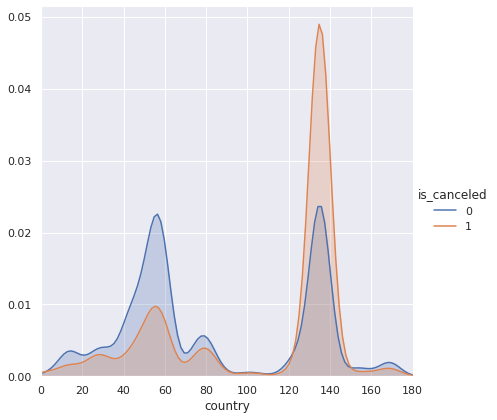

In [16]:
(sns.FacetGrid(data_raw, hue = 'is_canceled',
             height = 6,
             xlim = (0,180))
    .map(sns.kdeplot, 'country', shade = True)
    .add_legend())
pass

Результаты графика ниже интуитивно понятны: среди постоянных гостей меньше отмененных бронирований

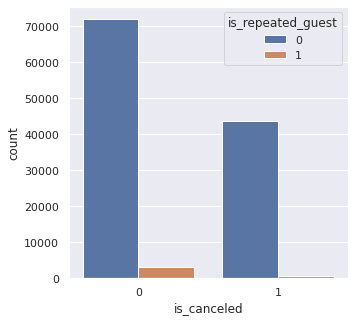

In [18]:
plt.figure(figsize = (5, 5))

sns.countplot(x='is_canceled', hue='is_repeated_guest', data=data_raw)
pass

Интересная зависимость отмен от количества времени, проведенного в ожидании подтверждения бронировния от отеля: прежде чем отменить бронь, люди ждут либо не долго( по сравнению с 400-мя днями) либо очень долго. В любом случае, чем больше времени проведенного в ожиданее, тем вероятней отмена.

<Figure size 1080x1080 with 0 Axes>

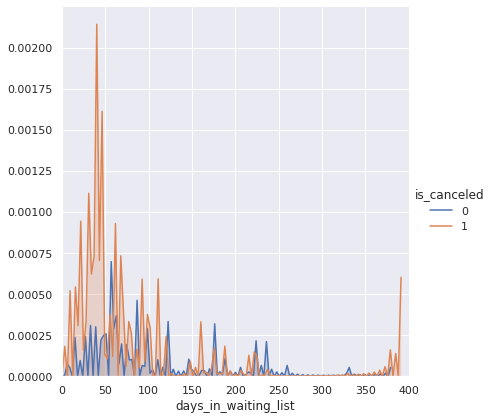

In [19]:
plt.figure(figsize = (15, 15))
(sns.FacetGrid(data_raw, hue = 'is_canceled',
             height = 6,
             xlim = (0,400))
    .map(sns.kdeplot, 'days_in_waiting_list', shade = True)
    .add_legend())
pass

Ниже представлена зависимость между временем ожидания и общим количеством заказов от клиента. Видно, что клиенты с далеко не первым бронированием практически всегда обслуживаются в первый день. А клиенты, у которых количество бронирований до 10 и которые ожидают более одного дня в основном отказываются от бронирования. 

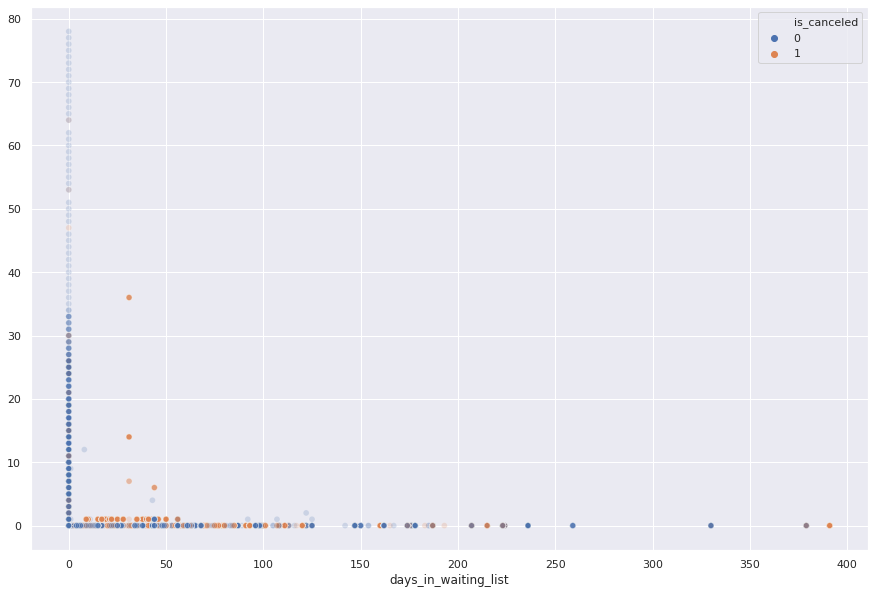

In [20]:
plt.figure(figsize = (15, 10))

all_boocking_count = data_raw['previous_cancellations'] + data_raw['previous_bookings_not_canceled']
total_time= data_raw['stays_in_weekend_nights'] + data_raw['stays_in_week_nights']
people_count = data_raw['adults'] + data_raw['children']+ data_raw['babies']

sns.scatterplot(x='days_in_waiting_list', y=all_boocking_count, hue='is_canceled', data=data_raw, alpha=0.2)
pass

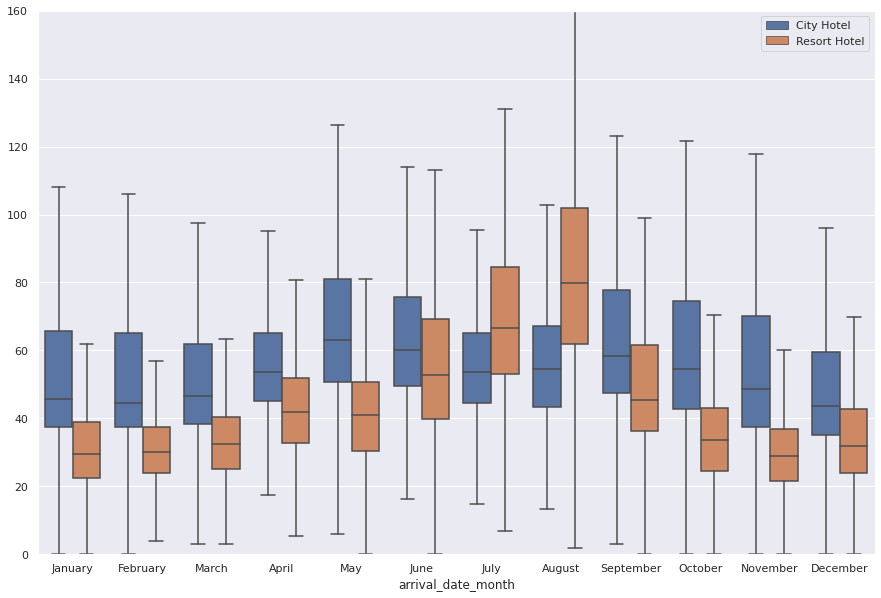

In [21]:
# Calculate price per night
full_data_guests = data_raw.loc[data_raw["is_canceled"] == 0] 

ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]

room_prices = full_data_guests.sort_values("arrival_date_month")

room_prices['arrival_date_month'] =pd.Categorical(room_prices["arrival_date_month"], categories=ordered_months, ordered=True)
adr_pp = room_prices["adr"] / (room_prices["adults"] + room_prices["children"])

plt.figure(figsize=(15, 10))
sns.boxplot(x="arrival_date_month",
            y=adr_pp,
            hue="hotel",
            data=room_prices,
            fliersize=0)
plt.legend(loc="upper right")
plt.ylim(0, 160)
plt.show()

Из графика ниже видно, что туристические агенства популярны круглый год, однако в августе через них поступает больше всего бронирований.

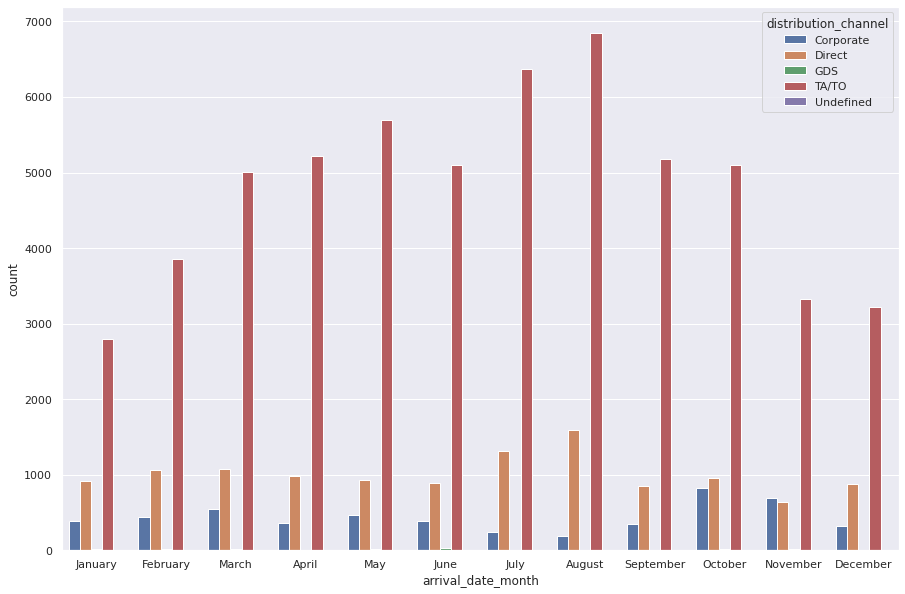

In [22]:
plt.figure(figsize=(15, 10))
sns.countplot(x=room_prices['arrival_date_month'], hue = 'distribution_channel', data=full_data_guests)
pass

Ниже зависимость от 'lead_time' и количеством дней, на которое бронируют отель. Видно, что курортные отели чаще всего бронируют на  6-7 дней, реже 13-14, и такие бронирования довольно редко отменяются.

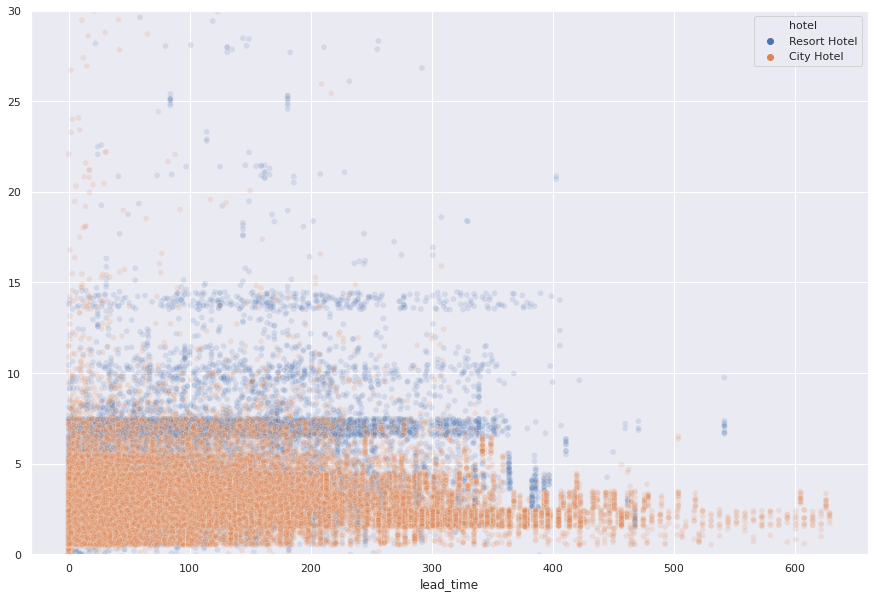

In [23]:
plt.figure(figsize=(15, 10))

random_subset = np.random.choice(np.arange(data_raw.shape[0]), size=50000, replace=False)
time_rnd = total_time + np.random.rand(data_raw.shape[0]) - .5
sns.scatterplot(x='lead_time', y=time_rnd, hue='hotel', data=data_raw.iloc[random_subset] , alpha=0.15)

plt.ylim(0, 30)
pass

Для городского отеля наиболее популярной явлется комната типа А, и скорее всего гости возвращаются и заселяются в этот же тип комнаты только благодаря ее популярности.

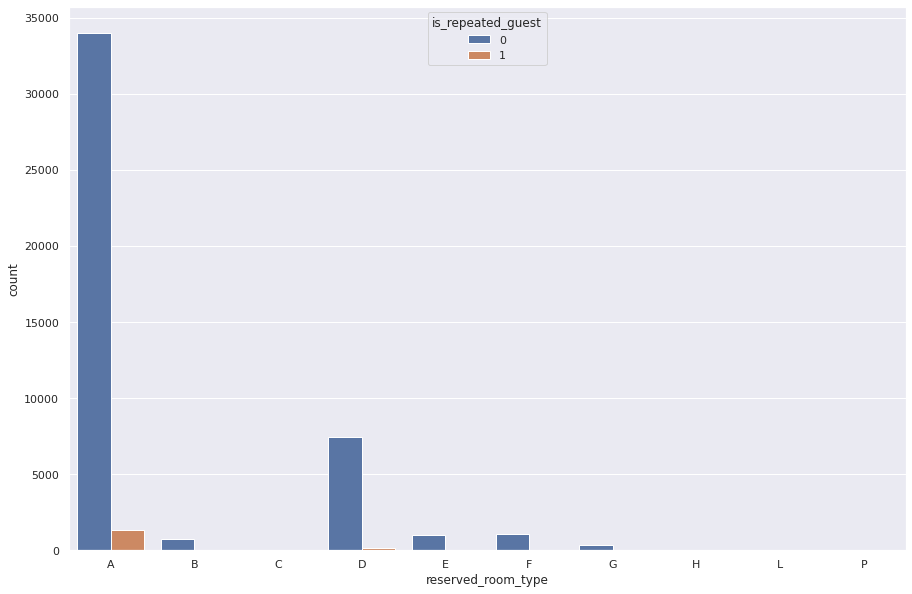

In [24]:
plt.figure(figsize=(15, 10))
city_guests = full_data_guests.loc[full_data_guests["hotel"] == "City Hotel"]
sns.countplot(x=city_guests['reserved_room_type'], hue = 'is_repeated_guest', data=city_guests)
pass

А вот для курортного отеля также популярны комнаты типа D и E.

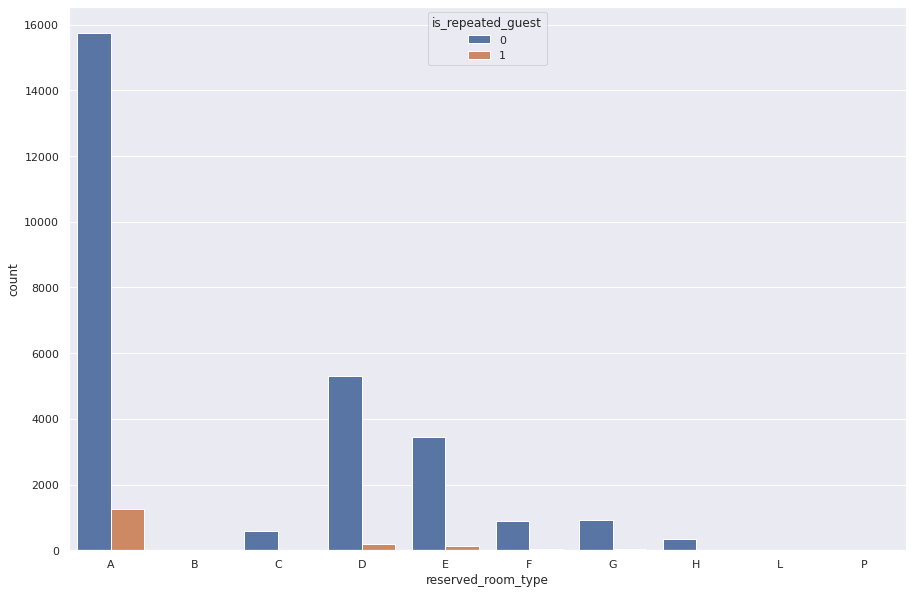

In [25]:
plt.figure(figsize=(15, 10))
resort_guests = full_data_guests.loc[full_data_guests["hotel"] == "Resort Hotel"]
sns.countplot(x=resort_guests['reserved_room_type'], hue = 'is_repeated_guest', data=resort_guests)
pass

## 3. Препроцессинг

### 3.1 Корреляция

In [26]:
from sklearn.preprocessing import LabelEncoder
corr_data = data_raw.copy()

le = LabelEncoder()

corr_data['hotel'] = le.fit_transform(corr_data['hotel'])
corr_data['arrival_date_month'] = le.fit_transform(corr_data['arrival_date_month'])
corr_data['meal'] = le.fit_transform(corr_data['meal'])
corr_data['distribution_channel'] = le.fit_transform(corr_data['distribution_channel'])
corr_data['reserved_room_type'] = le.fit_transform(corr_data['reserved_room_type'])
corr_data['assigned_room_type'] = le.fit_transform(corr_data['assigned_room_type'])
corr_data['customer_type'] = le.fit_transform(corr_data['customer_type'])
corr_data['reservation_status'] = le.fit_transform(corr_data['reservation_status'])
corr_data['market_segment'] = le.fit_transform(corr_data['market_segment'])
corr_data['deposit_type'] = le.fit_transform(corr_data['deposit_type'])

In [27]:
corr_mat = corr_data.corr()

In [28]:
corr_mat["is_canceled"].sort_values(ascending=False)

is_canceled                       1.000000
deposit_type                      0.468634
lead_time                         0.293123
country                           0.270254
distribution_channel              0.167600
previous_cancellations            0.110133
adults                            0.060017
market_segment                    0.059338
days_in_waiting_list              0.054186
adr                               0.047557
stays_in_week_nights              0.024765
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
children                          0.005048
arrival_date_month               -0.001491
stays_in_weekend_nights          -0.001791
arrival_date_day_of_month        -0.006130
meal                             -0.017678
company                          -0.020642
babies                           -0.032491
previous_bookings_not_canceled   -0.057358
reserved_room_type               -0.061282
customer_type                    -0.068140
reservation

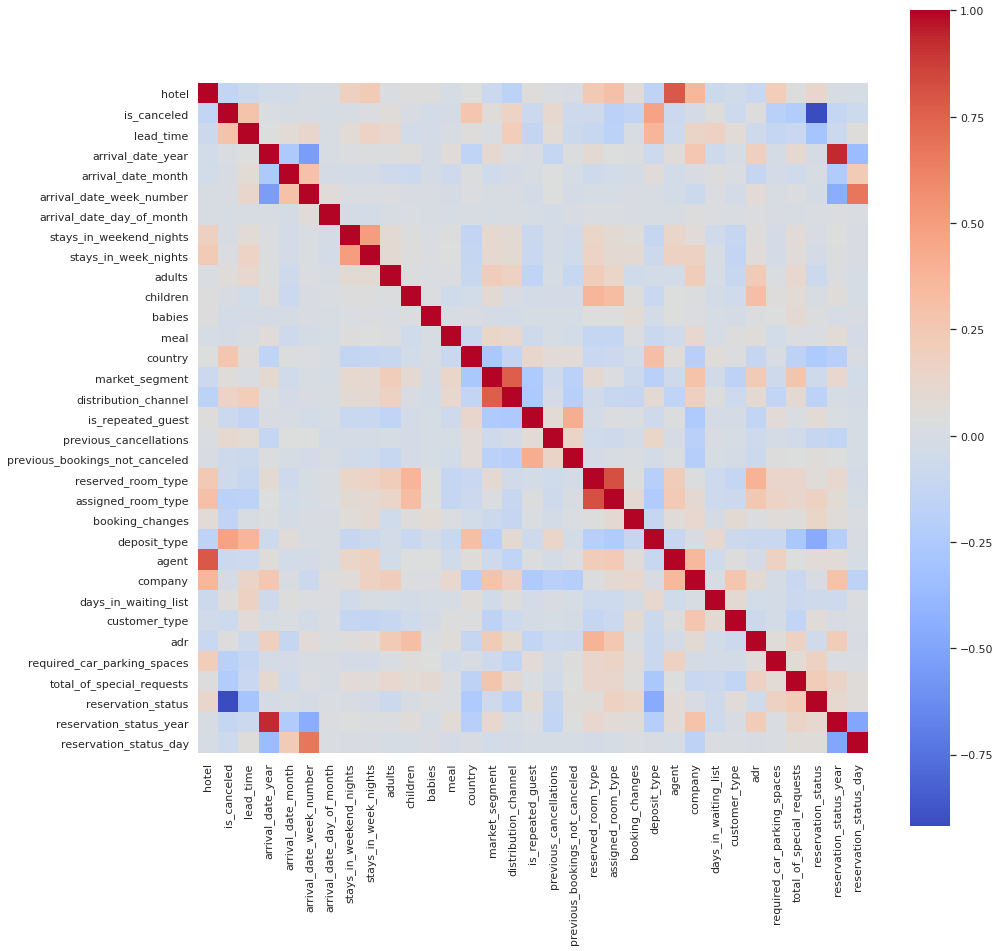

In [29]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

Исключим из датасета признаки с слишком низким коэффициентом корреляции: их влияние на предсказания несущественно: 

  * `arrival_date_week_number`          
  * `children`                          
  * `arrival_date_month`               
  * `stays_in_weekend_nights`          
  * `arrival_date_day_of_month`

In [30]:
data_raw = data_raw.drop(columns = ['arrival_date_week_number', 'stays_in_weekend_nights', 'arrival_date_month', 'children','arrival_date_day_of_month'], axis = 1)

### 3.2. Удаление пропущенных значений

Заменим пропущенные значения в номинальных признаках NaN для корректного подсчета количества пропущенных значений.

In [31]:
data_raw.loc[data_raw.meal == 'Undefined', 'meal'] = np.nan
data_raw.loc[data_raw.market_segment == 'Undefined', 'market_segment'] = np.nan
data_raw.loc[data_raw.distribution_channel == 'Undefined', 'distribution_channel'] = np.nan

In [32]:
print("# of NaN in each columns:", data_raw.isnull().sum(), sep='\n')

# of NaN in each columns:
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
stays_in_week_nights                   0
adults                                 0
babies                                 0
meal                                1169
country                              488
market_segment                         2
distribution_channel                   5
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces    

In [33]:
for feature in data_raw.columns:
  mv =  data_raw[feature].isnull().sum()
  if mv > 0:
    p = mv / len(data_raw[feature]) * 100
    print('{}\t\t\t->\t{}\t%'.format(feature, p))


meal			->	0.9791439819080325	%
country			->	0.40874445095904177	%
market_segment			->	0.0016751821760616465	%
distribution_channel			->	0.004187955440154116	%
agent			->	13.686238378423655	%
company			->	94.30689337465449	%


*   `company`- по большей части значения отсутствуют. В таком случае замена пропущенных значений средним или медианой не придаст точности модели. Поэтому признак `company` **удаляется**.
*   Значения признаков, у которых количество пропущенных значений меньше, чем один процент, заменим медианой/модой.
*   Признак `agent` удаляем, потому что он имеет достаточно большое количество значений и его влияние на предсказания есть, но оно не достаточно большое.


In [34]:
data_raw = data_raw.drop(columns = ['company', 'agent'], axis = 1)

In [35]:
data_raw['meal'].fillna(data_raw['meal'].mode().iloc[0], inplace=True)
data_raw['market_segment'].fillna(data_raw['market_segment'].mode().iloc[0], inplace=True)
data_raw['distribution_channel'].fillna(data_raw['distribution_channel'].mode().iloc[0], inplace=True)

In [36]:
data_raw['country'].fillna(data_raw['country'].median(axis = 0), axis=0 , inplace=True)

In [37]:
print("# of NaN in each columns:", data_raw.isnull().sum(), sep='\n')

# of NaN in each columns:
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
stays_in_week_nights              0
adults                            0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status                0
reservation_status_year           0
reservation_status_day            0
dtype: int64


### 3.3. Трансформация категориальных признаков


In [38]:
data_raw.dtypes

hotel                             category
is_canceled                          int64
lead_time                            int64
arrival_date_year                    int64
stays_in_week_nights                 int64
adults                               int64
babies                               int64
meal                              category
country                            float64
market_segment                    category
distribution_channel              category
is_repeated_guest                    int64
previous_cancellations               int64
previous_bookings_not_canceled       int64
reserved_room_type                category
assigned_room_type                category
booking_changes                      int64
deposit_type                      category
days_in_waiting_list                 int64
customer_type                     category
adr                                float64
required_car_parking_spaces          int64
total_of_special_requests            int64
reservation

`Resort Hotel` → 0, `City Hotel`→ 1

In [39]:
data_raw['hotel'] = pd.factorize(data_raw['hotel'])[0]

In [40]:
data_raw = pd.get_dummies(data = data_raw, columns = ['meal', 'market_segment', 'distribution_channel', 'reserved_room_type',
                                                     'assigned_room_type', 'deposit_type', 'customer_type'])

Также удаляем `reservation_status`- он в некотором смысле копирует предсказываемый признак. 

In [41]:
data_raw = data_raw.drop(columns = ['distribution_channel_Undefined', 'market_segment_Undefined', 'meal_Undefined', 'reservation_status'], axis = 1)

In [42]:
data_raw.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'stays_in_week_nights', 'adults', 'babies', 'country',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'reservation_status_year',
       'reservation_status_day', 'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC',
       'market_segment_Aviation', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA', 'distribution_channel_Corporate',
       'distribution_channel_Direct', 'distribution_channel_GDS',
       'distribution_channel_TA/TO', 'reserved_room_type_A',
       'reserved_room_type_B', 'reserved_room_type_C', 'reserved_room_type_D',
       'reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G',
      

### 3.4. Избавление от выбросов

На некоторых графиках можно заметить явные выбросы. Например ниже: 

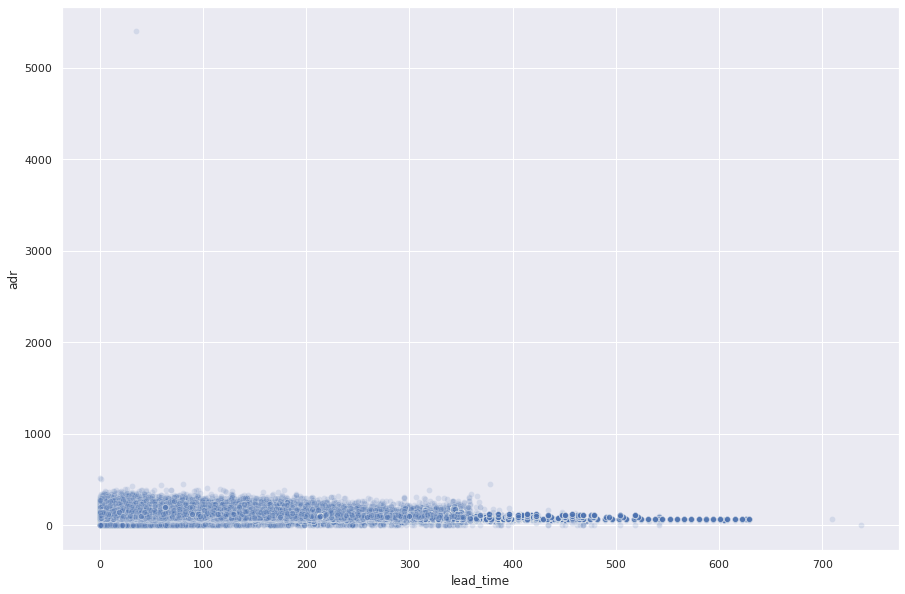

In [43]:
plt.figure(figsize=(15, 10))

sns.scatterplot(x='lead_time', y='adr', data=data_raw, alpha=0.15)

pass

In [44]:
data_raw = data_raw[data_raw['lead_time']<700]
data_raw = data_raw[data_raw['adr']<5000]

### 3.5. Стандартизация

In [45]:
data_stand = (data_raw - data_raw.mean(axis = 0))/data_raw.std(axis = 0)

## 4. Построение и сравнение моделей

In [46]:
from sklearn import metrics as metrics


def METRICS(y_true, y_pred, y_prob):
    y_pred = np.around(y_pred, 0)

    acc = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)

    false_positive_rate, true_positive_rate, threshold = metrics.roc_curve(y_true, y_prob)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)

    return {
        'acc': acc,
        'recall': recall,
        'precision': precision,
        'auc': roc_auc
    }

In [47]:
def ROC(y_true, y_prob):
    
    false_positive_rate, true_positive_rate, threshold = metrics.roc_curve(y_true, y_prob)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    plt.figure(figsize = (10,10))
    plt.plot(false_positive_rate, true_positive_rate, color = 'red', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linestyle = '--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [48]:
def CONFUSION(y_test, y_test_predict):
     sns.heatmap(metrics.confusion_matrix(y_test, y_test_predict), annot=True)

In [49]:
def learn_and_test_model(model, params, x_train, y_train, x_test, y_test):
    grid = GridSearchCV(model(), params, verbose=1, cv=3)
    grid.fit(x_train, y_train)

    best_cv_err = 1 - grid.best_score_

    print("\nBest CV error\t{}\n".format(best_cv_err))

    print("\nBest parameters:\n")
    best_params = {}
    for param_name in params:
      print("\t", param_name,"\t", getattr(grid.best_estimator_, param_name))
      best_params[param_name] = getattr(grid.best_estimator_, param_name)

    learned_model = model(**best_params).fit(x_train, y_train)

    err_train = np.mean(y_train != learned_model.predict(x_train))
    err_test  = np.mean(y_test  != learned_model.predict(x_test))

    print("\nTrain error:\t{}\nTest error:\t{}\n".format(err_train, err_test))

    y_test_predict = learned_model.predict(x_test)
    y_prob = learned_model.predict_proba(x_test)[:,1]

    print("Metrics:\n")
    model_metrics = METRICS(y_test, y_test_predict, y_prob)
    print(model_metrics)
    CONFUSION(y_test, y_test_predict)
    ROC(y_test, y_prob)
    return learned_model, model_metrics

### 4.1. Разбиение на выборки

In [50]:
X = data_stand.drop(["is_canceled"], axis=1)
Y = data_raw['is_canceled']

In [51]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)

n_train, _ = x_train.shape 
n_test,  _ = x_test.shape 

n_train, n_test

(89540, 29847)

### 4.2. Метод ближайшего соседа

In [53]:
from sklearn.model_selection import GridSearchCV

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed: 72.8min finished



Best CV error	0.1373687812504737


Best parameters:

	 n_neighbors 	 3

Train error:	0.06832700469064105
Test error:	0.13113545749991623

Metrics:

{'acc': 0.8688645425000837, 'recall': 0.7975147505810835, 'precision': 0.84399243140965, 'auc': 0.9125226824320206}


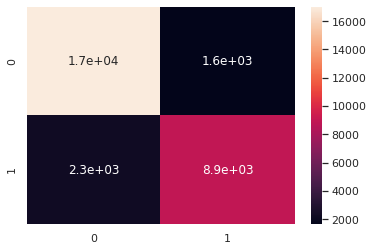

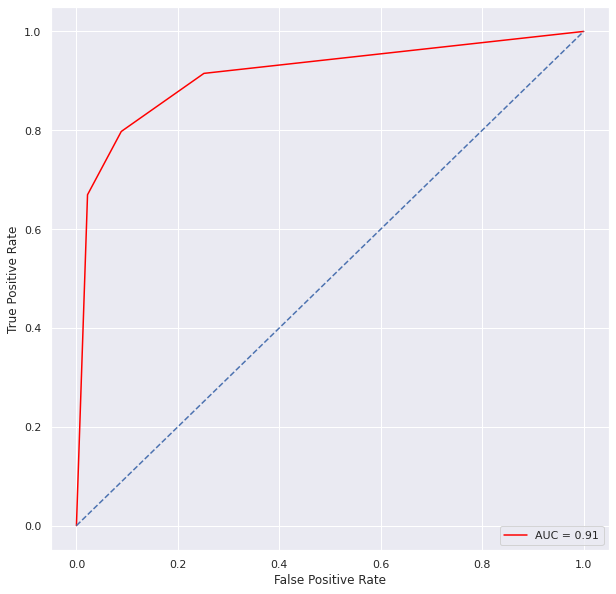

In [113]:
from sklearn.neighbors import KNeighborsClassifier

params = { 
    'n_neighbors': [1, 3, 5, 10, 15, 20, 25]
}

knn_learned_model, knn_model_metrics = learn_and_test_model(KNeighborsClassifier, params, x_train, y_train, x_test, y_test)

### 4.3. Дерево решений

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   37.4s finished



Best CV error	0.128646417412012


Best parameters:

	 min_samples_split 	 4
	 max_depth 	 14

Train error:	0.10519320973866428
Test error:	0.12771802861259088

Metrics:

{'acc': 0.8722819713874091, 'recall': 0.7966207759699625, 'precision': 0.8528905053598775, 'auc': 0.9349859012045427}


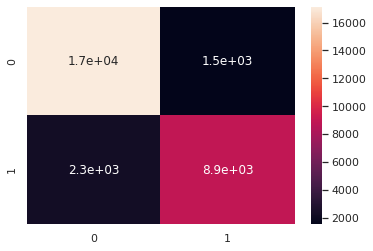

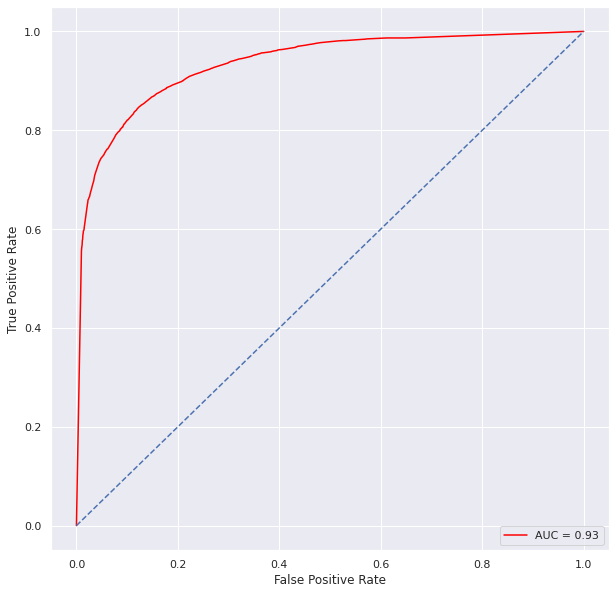

In [114]:
from sklearn.tree import DecisionTreeClassifier

params = { 
    'min_samples_split': [2, 3, 4],
    'max_depth' : list(range(5, 15))
}

tree_learned_model, tree_model_metrics = learn_and_test_model(DecisionTreeClassifier, params, x_train, y_train, x_test, y_test)

### 4.4. Random Forest

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 25.5min finished



Best CV error	0.19106544017044647


Best parameters:

	 n_estimators 	 1000
	 max_depth 	 8
	 min_samples_split 	 4

Train error:	0.19182488273397363
Test error:	0.19630113579254196

Metrics:

{'acc': 0.8036988642074581, 'recall': 0.490613266583229, 'precision': 0.9714993804213135, 'auc': 0.9222325325069068}


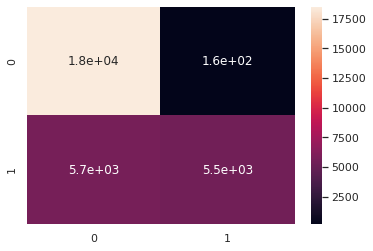

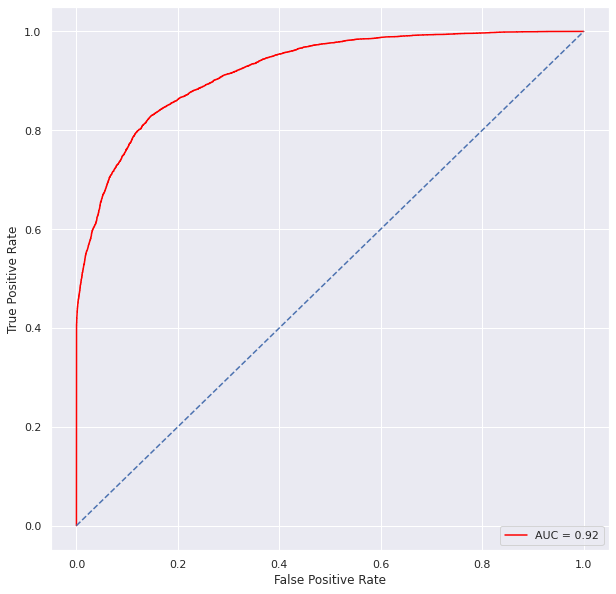

In [59]:
from sklearn.ensemble import RandomForestClassifier

params = { 
    'n_estimators': [200, 500, 1000],
    'max_depth' : [4, 6, 8],
    'min_samples_split': [2, 3, 4],
}

forest_learned_model,  forest_model_metrics = learn_and_test_model(RandomForestClassifier, params, x_train, y_train, x_test, y_test)

### 4.5. AdaBoost

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  7.1min finished



Best CV error	0.14441589892783124


Best parameters:

	 n_estimators 	 1000

Train error:	0.1427741791378155
Test error:	0.14597782021643715

Metrics:

{'acc': 0.8540221797835629, 'recall': 0.7319864115859109, 'precision': 0.8576516183094166, 'auc': 0.9269320263977993}


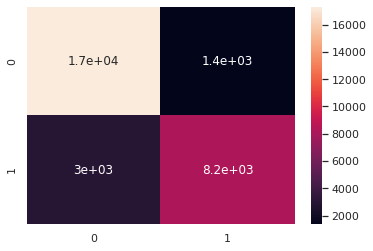

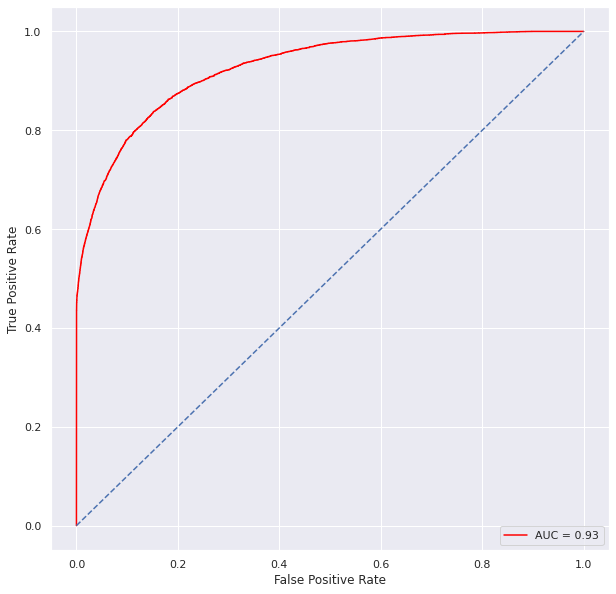

In [116]:
from sklearn.ensemble import AdaBoostClassifier

params = { 
    'n_estimators': [200, 500, 1000]
}

ada_learned_model, ada_model_metrics = learn_and_test_model(AdaBoostClassifier, params, x_train, y_train, x_test, y_test)

### 4.6. Logistic Regression

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 11.5min finished



Best CV error	0.16564664739578816


Best parameters:

	 solver 	 liblinear
	 C 	 10.481131341546853

Train error:	0.16523341523341523
Test error:	0.16507521693972593

Metrics:

{'acc': 0.8349247830602741, 'recall': 0.6700339710352226, 'precision': 0.8584354598556866, 'auc': 0.8971346947201498}


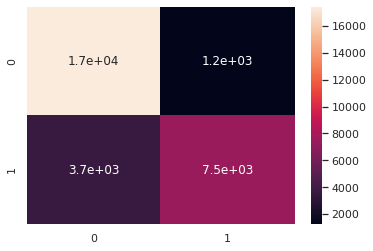

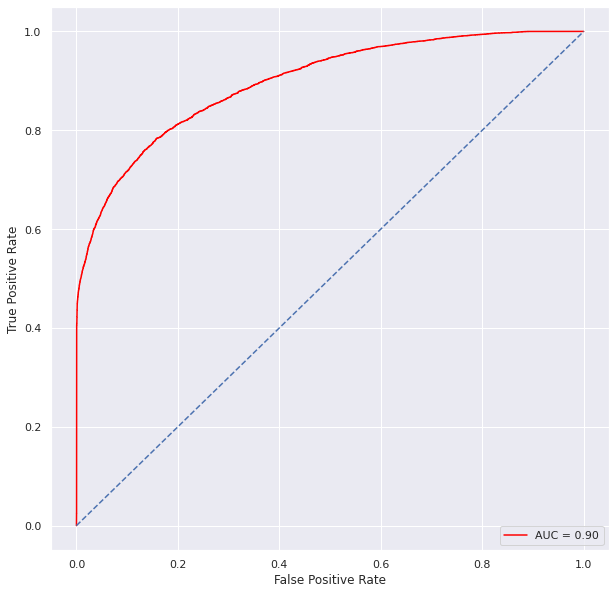

In [56]:
from sklearn.linear_model import LogisticRegression

params = { 
    'solver': ['liblinear'],
    'C': np.logspace(-2, 2, 50)
}

lr_learned_model, lr_model_metrics = learn_and_test_model(LogisticRegression, params, x_train, y_train, x_test, y_test)

### 4.7. Naive Bayes

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished



Best CV error	0.24633686818521972


Best parameters:


Train error:	0.24861514406968951
Test error:	0.2533252923241867

Metrics:

{'acc': 0.7466747076758133, 'recall': 0.34087251922045414, 'precision': 0.9530117470632342, 'auc': 0.782379378603666}


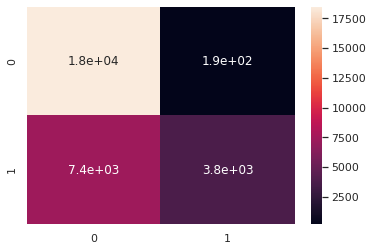

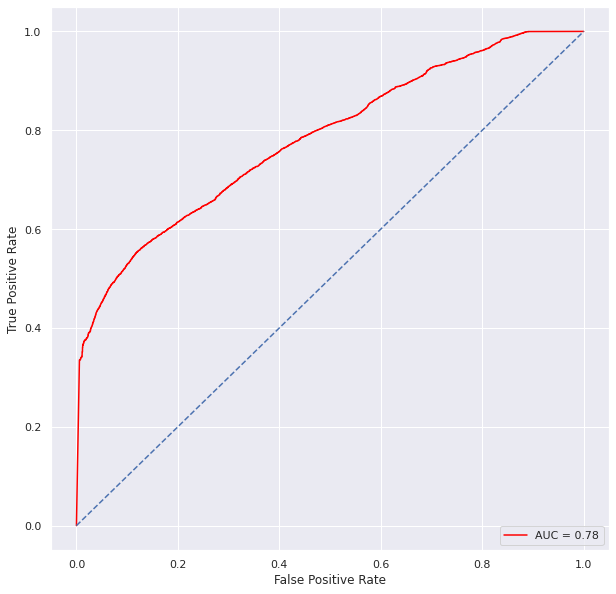

In [57]:
from sklearn.naive_bayes import GaussianNB

params = {}

nb_learned_model, nb_model_metrics = learn_and_test_model(GaussianNB, params, x_train, y_train, x_test, y_test)

### 5. Выводы

Text(0.5, 0, 'Feature Importances (%)')

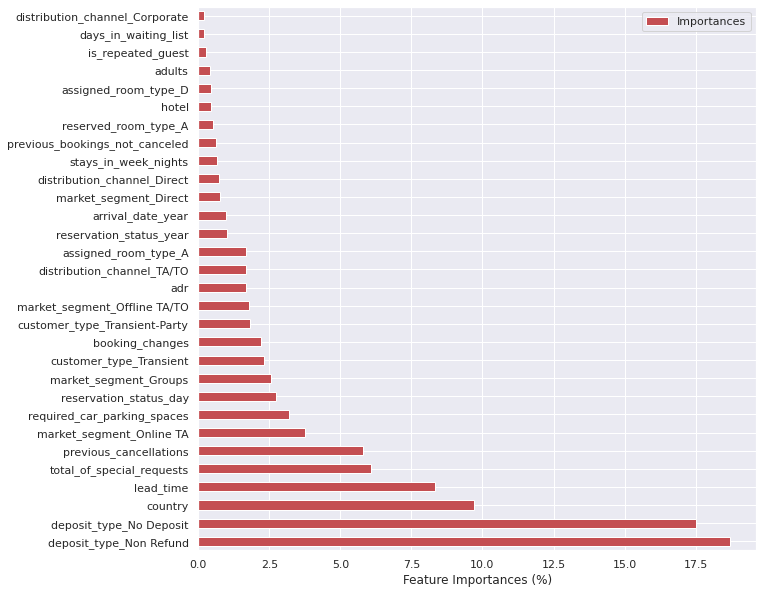

In [60]:
importances = pd.DataFrame(data = forest_learned_model.feature_importances_*100,
                   columns = ["Importances"],
                   index = x_train.columns).sort_values("Importances", ascending = False)

importances[:30].plot(kind = "barh", color = "r", figsize=(10,10))
plt.xlabel("Feature Importances (%)")

In [71]:
all_model_metric = [knn_model_metrics, tree_model_metrics, forest_model_metrics, ada_model_metrics, lr_model_metrics, nb_model_metrics]
acc= list(map(lambda x: x['acc'], all_model_metric))
recall= list(map(lambda x: x['recall'], all_model_metric))
precision = list(map(lambda x: x['precision'], all_model_metric))
roc_auc = list(map(lambda x: x['auc'], all_model_metric))

table = pd.DataFrame({"Model": [ "kNN", "Decision Tree", "Random Forest", "AdaBoost", "Logistic Regression",
                                "Naive Bayes"],
                     "Accuracy Scores": acc,
                     "Recall Scores": recall,
                     "Precision Scores": precision,
                     "ROC | Auc": roc_auc})


table["Model"] = table["Model"].astype("category")
table["Accuracy Scores"] = table["Accuracy Scores"].astype("float32")
table["Recall Scores"] = table["Accuracy Scores"].astype("float32")
table["Precision Scores"] = table["Accuracy Scores"].astype("float32")
table["ROC | Auc"] = table["ROC | Auc"].astype("float32")

pd.pivot_table(table, index = ["Model"]).sort_values(by = 'ROC | Auc', ascending=False)

,Accuracy Scores,Precision Scores,ROC | Auc,Recall Scores
Model,,,,
Decision Tree,0.87,0.87,0.93,0.87
AdaBoost,0.85,0.85,0.92,0.85
Random Forest,0.80,0.80,0.92,0.80
kNN,0.87,0.87,0.91,0.87
Logistic Regression,0.83,0.83,0.90,0.83
Naive Bayes,0.74,0.74,0.78,0.74


Итак, сделаем выводы по результатом обущения моделей:


*   Модели для бинарной классификации лучше выбирать по метрике AUC и самые высокие показатели имеет дерево решений. У этой модели также самые высокие оценки по остальным метрикам, в том числе и ошибкам на обучающей и тестовой выборках.
*   Как следует из графика важности признаков, для предсказания отмены важно наличие депозита, страна (было замечено на этапе визуализации), а также время до заселения, за которое делается бронирование
*   Точность моделей довольно низкая - у дерева решений ошибка 12%. Поэтому имеет смысл посмотреть в сторону нелинейных моделей для классификации, то есть нейронных сетей. 